# Build a simple neural network in ORT and train it to recognize handwritten digits using the MNIST dataset. (On-Device Training)

Ref: https://github.com/microsoft/onnxruntime-training-examples/blob/master/on_device_training/desktop/python/mnist.ipynb

Ref2: https://onnxruntime.ai/docs/api/python/on_device_training/training_api.html#onnxruntime.training.api.Optimizer

This tutorial has two sections:

1. Offline Phase - Preparing training artifacts that will be consumed in the training phase.
2. Training Phase - Train the model on the device.


#### Importing libraries

Make sure to install onnxruntime-training's nightly version.

```pip install onnxruntime-training```

In [1]:
# @title ONNX and ONNXruntime installation
!pip install onnx onnxruntime netron evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.1 MB/s eta 0:00:00


In [2]:
# @title Install ONNXruntime 1.15.0 (first) then >=1.18.0 (second)
"""
Arg:
  Remark ---> onnxruntime-training installation for 'onnxblock' sub-function API
  onnxruntime-training available version (1.15.0, 1.15.1, 1.16.0, 1.16.2, 1.16.3, 1.17.1, 1.17.3, 1.18.0, 1.19.1, 1.19.2)
  Step 1: Install onnxruntime-training version 1.15.0
  Step 2: Install onnxruntime-training version 1.18.0
"""
!pip install onnxruntime-training==1.15.0
!pip install onnxruntime-training==1.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.4/294.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.0/279.0 MB 4.7 MB/s eta 0:00:00
  Attempting uninstall: onnxruntime-training
    Found existing installation: onnxruntime-training 1.15.0
    Uninstalling onnxruntime-training-1.15.0:
      Successfully uninstalled onnxruntime-training-1.15.0


-----
## 0 - Library Preparation

In [3]:
import onnx
import onnxruntime.training.onnxblock as onnxblock
from onnxruntime.training.api import CheckpointState, Module, Optimizer
from onnxruntime.training import artifacts
from onnxruntime import InferenceSession
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import io
import os
import netron
import evaluate

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_validation.py:114: UserWarning: WARNING: failed to get cudart_version from onnxruntime build info.
  warnings.warn("WARNING: failed to get cudart_version from onnxruntime build info.")


In [4]:
# Hyper-parameter
image_size = 28
batch_size = 64
test_batch_size = 64
# VVVVVVVVVVV
NN = 'mlp'  # Optional: {'mlp', 'cnn'}
# AAAAAAAAAAA

## 1 - Offline Step

To run your training loop, first you need to generate training, eval (optional) and optimizer graphs.

We expect the users to have an onnx forward only model, you can generate this model with different ways, in this example we will be using torch.export to generate this model.

In [5]:
# Pytorch class that we will use to generate the graphs.
class MNISTNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MNISTNet, self).__init__()

        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, model_input):
        out = self.fc1(model_input)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # Input channel, output channel, kernel size
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create a MNISTNet instance.
device = "cpu"
if NN == 'mlp':
  input_size, hidden_size, output_size = 784, 500, 10
  pt_model = MNISTNet(input_size, hidden_size, output_size).to(device)
  model_inputs = (torch.randn(batch_size, input_size, device=device),)
elif NN == 'cnn':
  pt_model = LeNet5(num_classes=10).to(device)
  model_inputs = (torch.randn(batch_size, 1, image_size, image_size, device=device),)

### Generating forward only graph.

In [6]:
model_outputs = pt_model(*model_inputs)
if isinstance(model_outputs, torch.Tensor):
    model_outputs = [model_outputs]

input_names = ["input"]
output_names = ["output"]
dynamic_axes = {"input": {0: "batch_size"}, "output": {0: "batch_size"}}

# f = io.BytesIO()
if not os.path.exists("data"): os.makedirs("data")
torch.onnx.export(
    pt_model,
    model_inputs,
    'data/training_model.onnx',
    # f,
    input_names=input_names,
    output_names=output_names,
    opset_version=14,
    do_constant_folding=False,
    training=torch.onnx.TrainingMode.TRAINING,
    dynamic_axes=dynamic_axes,
    export_params=True,
    keep_initializers_as_inputs=False,
)
# onnx_model = onnx.load_model_from_string(f.getvalue())
onnx_model = onnx.load("data/training_model.onnx")

#### After creating forward only graph, we can now create the training graph.

##### **Method 1:**

Alternatively, you can use the generate_artifacts function provided by the onnxblock library. This function automatically generates a training graph based on the forward-only graph and the specified loss function.

In [7]:
requires_grad = [name for name, param in pt_model.named_parameters() if param.requires_grad]
frozen_params = [name for name, param in pt_model.named_parameters() if not param.requires_grad]

artifacts.generate_artifacts(
    onnx_model,
    optimizer=artifacts.OptimType.AdamW,
    loss=artifacts.LossType.CrossEntropyLoss,
    requires_grad=requires_grad,
    frozen_params=frozen_params,
    artifact_directory="data",
    additional_output_names=["output"],
)

##### **Method 2:**

The first step is creating a simple class that inherits from onnxblock.TrainingModel, and define the loss function.
the build function defines the output of our model.

In [8]:
# Creating a class with a Loss function.
class MNISTTrainingBlock(onnxblock.TrainingBlock):
    def __init__(self):
        super(MNISTTrainingBlock, self).__init__()
        self.loss = onnxblock.loss.CrossEntropyLoss()

    def build(self, output_name):
        return self.loss(output_name), output_name

In [9]:
# Build the onnx model with loss
training_block = MNISTTrainingBlock()
for param in onnx_model.graph.initializer:
    print(param.name)
    training_block.requires_grad(param.name, True)

# Building training graph and eval graph.
model_params = None
with onnxblock.base(onnx_model):
    _ = training_block(*[output.name for output in onnx_model.graph.output])
    training_model, eval_model = training_block.to_model_proto()
    model_params = training_block.parameters()

# Building the optimizer graph
optimizer_block = onnxblock.optim.AdamW()
with onnxblock.empty_base() as accessor:
    _ = optimizer_block(model_params)
    optimizer_model = optimizer_block.to_model_proto()

fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [10]:
# Saving all the files to use them later for the training.
onnxblock.save_checkpoint(training_block.parameters(), "data/checkpoint.ckpt")  # /checkpoint.ckpt onnxrt-training for >==1.15.0 elif lower then /checkpoint
onnx.save(training_model, "data/training_model.onnx")
onnx.save(optimizer_model, "data/optimizer_model.onnx")
onnx.save(eval_model, "data/eval_model.onnx")

#### You can use netron to visualize the graphs.
This is an example of how an eval graph looks like

In [11]:
netron.start("data/eval_model.onnx")

Serving 'data/eval_model.onnx' at http://localhost:8081


('localhost', 8081)

![](graph.png)

## 2 - Data Preparation
we're going to use datasets to load the MNIST Dataset and then we'll wrap it in a DataLoader.

In [12]:
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11528013.42it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 348996.66it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3155294.58it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8315377.03it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## 3 - Initialize Module and Optimizer
We will use the saved files to initialize the state, model and optimizer.
Note that the eval graph is optional.

In [13]:
# # !pip install --upgrade onnxruntime onnxruntime-training

# # Create checkpoint state.
# state = CheckpointState.load_checkpoint("data/checkpoint.ckpt")

# # Create module.
# model = Module("data/training_model.onnx", state, "data/eval_model.onnx")

# # Create optimizer.
# # optimizer = Optimizer("data/optimizer_model.onnx", model)
# # optimizer_block = onnxblock.optim.AdamW()

In [14]:
# Load the optimizer model
model = onnx.load("data/optimizer_model.onnx")

# Change the opset import to a supported version (e.g., 21)
for opset_import in model.opset_import:
    if opset_import.domain == "" or opset_import.domain == "ai.onnx":  # Target the default ONNX domain
        opset_import.version = 21  # Change to the desired opset version
        break  # Assuming only one ONNX domain is imported

# Save the modified model
onnx.save(model, "data/optimizer_model_opset21.onnx")

# Now use the modified model path when creating the Optimizer
from onnxruntime.training.api import Optimizer, Module, CheckpointState

state = CheckpointState.load_checkpoint("data/checkpoint.ckpt")
model = Module("data/training_model.onnx", state, "data/eval_model.onnx")

optimizer_uri = "data/optimizer_model_opset21.onnx"  # Use the modified model
optimizer = Optimizer(optimizer_uri, model)

## 4 - Run Training and Testing Loops
In this step we will define training and testing loops.
The steps for training are simple :

1 - set model to train mode : model.train()

2 - prepare the input by making sure all inputs are numpy arrays

3 - pass the input to the model : model(input)

4 - call optimizer.step()


In [15]:
# Util function to convert logits to predictions.
def get_pred(logits):
    return np.argmax(logits, axis=1)

# Training Loop :
def train(epoch):
    model.train()
    losses = []
    for _, (data, target) in enumerate(train_loader):
        forward_inputs = [data.reshape(len(data),784).numpy(),target.numpy().astype(np.int64)] if NN == 'mlp' \
        else [data.numpy(),target.numpy().astype(np.int64)]
        train_loss, _ = model(*forward_inputs)
        optimizer.step()
        model.lazy_reset_grad()
        losses.append(train_loss)

    print(f'Epoch: {epoch+1},Train Loss: {sum(losses)/len(losses):.4f}')

# Test Loop :
def test(epoch):
    model.eval()
    losses = []
    metric = evaluate.load('accuracy')

    for _, (data, target) in enumerate(train_loader):
        forward_inputs = [data.reshape(len(data),784).numpy(),target.numpy().astype(np.int64)] if NN == 'mlp' \
        else [data.numpy(),target.numpy().astype(np.int64)]
        test_loss, logits = model(*forward_inputs)
        metric.add_batch(references=target, predictions=get_pred(logits))
        losses.append(test_loss)

    metrics = metric.compute()
    print(f'Epoch: {epoch+1}, Test Loss: {sum(losses)/len(losses):.4f}, Accuracy : {metrics["accuracy"]:.4f}')



In [16]:
for epoch in range(5):
    train(epoch)
    test(epoch)

Epoch: 1,Train Loss: 0.2184


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch: 1, Test Loss: 0.1154, Accuracy : 0.9630
Epoch: 2,Train Loss: 0.0898
Epoch: 2, Test Loss: 0.0659, Accuracy : 0.9785
Epoch: 3,Train Loss: 0.0570
Epoch: 3, Test Loss: 0.0503, Accuracy : 0.9827
Epoch: 4,Train Loss: 0.0403
Epoch: 4, Test Loss: 0.0456, Accuracy : 0.9841
Epoch: 5,Train Loss: 0.0292
Epoch: 5, Test Loss: 0.0349, Accuracy : 0.9879


## 5 - Run Inferencing
In this step we will use InferenceSession to run inferencing.

In [17]:
model.export_model_for_inferencing("data/inference_model.onnx",["output"])
session = InferenceSession('data/inference_model.onnx',providers=['CPUExecutionProvider'])

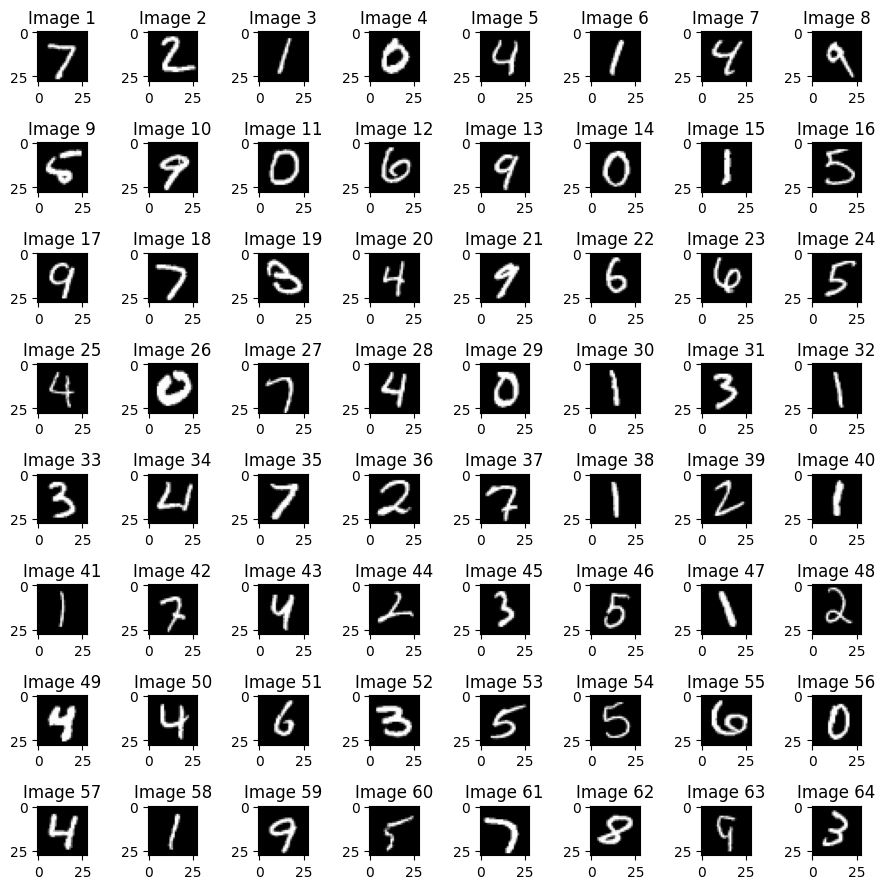





Predicted Label :  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 5 3]


In [18]:
# getting one example from test list to try inference.
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
if NN == 'mlp':
  data = next(iter(test_loader))[0]
  output = session.run([output_name], {input_name: data.reshape(-1,784).numpy()})
  #---single image plot
  # plt.imshow(data[0], cmap='gray')
  # plt.show()
  #---batch plot
  num_images = len(data)
  rows = int(np.ceil(np.sqrt(num_images)))
  cols = int(np.ceil(num_images / rows))
  fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
  for i, ax in enumerate(axes.flatten()):
      if i < num_images:
          ax.imshow(data[i].squeeze(0), cmap='gray')
          ax.set_title(f'Image {i+1}')
      else:
        ax.axis('off')  # Hide empty subplots
  plt.tight_layout()
  plt.show()
  print("\n"*3)
  print("Predicted Label : ",get_pred(output[0]))
elif NN == 'cnn':
  data = next(iter(test_loader))[0]
  output = session.run([output_name], {input_name: data.numpy()})
  #---single image plot
  # plt.imshow(data[0].squeeze(0), cmap='gray')
  # plt.show()
  #---batch plot
  num_images = len(data)
  rows = int(np.ceil(np.sqrt(num_images)))
  cols = int(np.ceil(num_images / rows))
  fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
  for i, ax in enumerate(axes.flatten()):
      if i < num_images:
          ax.imshow(data[i].squeeze(0), cmap='gray')
          ax.set_title(f'Image {i+1}')
      else:
        ax.axis('off')  # Hide empty subplots
  plt.tight_layout()
  plt.show()
  print("\n"*3)
  print("Predicted Label : ",get_pred(output[0]))


-------
# Homework

สร้างโมเดลจาก

\
1.1) LeNet-5\
1.2) GoogLeNet (Train from scratch) or SqueezeNet (Model from torchvision)

\
แต่ export ไปเป็น ONNX format และ**ฝึกฝนผ่าน ONNXRuntime** ผ่าน CPU (Setting: 5 iterations)



```
#---SimpleCNN from scratch---
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(GoogLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.inception_block1 = Inception(64, 64, 64, 64, 32, 32)
        self.inception_block2 = Inception(128, 128, 128, 128, 64, 64)
        self.inception_block3 = Inception(256, 256, 256, 256, 128, 128)
        self.inception_block4 = Inception(512, 512, 512, 512, 256, 256)
        self.inception_block5 = Inception(1024, 1024, 1024, 1024, 512, 512)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)

        x = self.inception_block1(x)
        x = self.inception_block2(x)
        x = self.inception_block3(x)
        x = self.inception_block4(x)
        x = self.inception_block5(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Inception(nn.Module):
    def __init__(self, in_channels, channels_1x1, channels_3x3_reduce, channels_3x3, channels_5x5_reduce, channels_5x5):
        super(Inception, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, channels_1x1, kernel_size=1),
            nn.BatchNorm2d(channels_1x1),
            nn.ReLU(inplace=True)
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, channels_3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(channels_3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels_3x3_reduce, channels_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels_3x3),
            nn.ReLU(inplace=True)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, channels_5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(channels_5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels_5x5_reduce, channels_5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(channels_5x5),
            nn.ReLU(inplace=True)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, channels_5x5, kernel_size=1),
            nn.BatchNorm2d(channels_5x5),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        x = torch.cat([branch1, branch2, branch3, branch4], 1)
        return x

model_googlenet = GoogLeNet().to(device)







#---SqueezeNet from Torchvision model---
from torchvision import models

model_sqnet = models.squeezenet1_0(weights='DEFAULT').to(device)
or
model_sqnet = models.squeezenet1_0(weights=None)
state_dict = torch.load("squeezenet1_0_weights.pth")
model_sqnet.load_state_dict(state_dict)
```

